In [ ]:
"""
EV Bus visualization script for Jupyter Notebook.

This reads a JSON file with fields like:
{
    "T": "0:360",
    "B": [1,2,3,4],
    "L": 1,
    "tau": 10,
    "c_max": 30,
    "w_max": 60,
    "arrivals": {"CEI": {"1": 0, ...}, "T2": {...}},
    "initial_positions": [{"bus": 1, "terminal": "CEI"}, ...]
}

It will:
    - Print a summary of key parameters
    - Build tidy and wide tables of arrivals
    - Plot arrivals per time step and cumulative arrivals (one figure per plot)
    - Save all figures to ./evbus_viz_<json_basename>/
"""

import json
from pathlib import Path
from typing import Any, Dict, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_case(path: Path) -> Dict[str, Any]:
        with open(path, "r", encoding="utf-8") as f:
                return json.load(f)

def arrivals_to_tidy(arrivals: Dict[str, Dict[str, int]]) -> pd.DataFrame:
        rows = []
        for terminal, series in arrivals.items():
                for t_str, val in series.items():
                        rows.append({"t": int(t_str), "terminal": terminal, "arrivals": int(val)})
        df = pd.DataFrame(rows).sort_values(["t", "terminal"]).reset_index(drop=True)
        return df

def initial_positions_df(initial_positions: List[Dict[str, Any]]) -> pd.DataFrame:
        if not initial_positions:
                return pd.DataFrame(columns=["bus", "terminal"])
        return pd.DataFrame(initial_positions)

def summarize_case(case: Dict[str, Any]) -> pd.DataFrame:
        B = case.get("B", [])
        if isinstance(B, list):
                num_buses = len(B)
        else:
                num_buses = 0

        ip = case.get("initial_positions", [])
        df_ip = initial_positions_df(ip)
        term_counts = df_ip["terminal"].value_counts() if not df_ip.empty else pd.Series(dtype=int)

        total_by_term = {}
        if "arrivals" in case and isinstance(case["arrivals"], dict):
                for term, series in case["arrivals"].items():
                        try:
                                total_by_term[term] = int(np.sum(list(map(int, series.values()))))
                        except Exception:
                                total_by_term[term] = np.nan

        params = {
                "NumBuses": num_buses,
                "Tau": case.get("tau"),
                "C_max": case.get("c_max"),
                "W_max": case.get("w_max"),
                "T": case.get("T"),
                "InitPos_CEI": int(term_counts.get("CEI", 0)),
                "InitPos_T2": int(term_counts.get("T2", 0)),
                "TotalArrivals_CEI": total_by_term.get("CEI", np.nan),
                "TotalArrivals_T2": total_by_term.get("T2", np.nan),
                "TotalArrivals_All": sum(v for v in total_by_term.values()) if total_by_term else np.nan,
        }
        return pd.DataFrame([params])

def plot_arrivals(df_tidy: pd.DataFrame, out_dir: Path = None, title_prefix: str = "") -> None:
        terminals = sorted(df_tidy["terminal"].unique())

        # per-time-step plots
        for term in terminals:
                d = df_tidy[df_tidy["terminal"] == term]
                fig = plt.figure()
                plt.plot(d["t"].values, d["arrivals"].values, marker="o")
                plt.xlabel("Time step (t)")
                plt.ylabel("Arrivals")
                plt.title(f"{title_prefix} — Arrivals per t at {term}")
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                if out_dir:
                        fig.savefig(out_dir / f"{title_prefix}_arrivals_{term}.png", dpi=140, bbox_inches="tight")
                        plt.close(fig)
                else:
                        plt.show()

        # cumulative plots
        for term in terminals:
                d = df_tidy[df_tidy["terminal"] == term].copy()
                d["cum"] = d["arrivals"].cumsum()
                fig = plt.figure()
                plt.plot(d["t"].values, d["cum"].values, marker="o")
                plt.xlabel("Time step (t)")
                plt.ylabel("Cumulative arrivals")
                plt.title(f"{title_prefix} — Cumulative arrivals at {term}")
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                if out_dir:
                        fig.savefig(out_dir / f"{title_prefix}_cumulative_{term}.png", dpi=140, bbox_inches="tight")
                        plt.close(fig)
                else:
                        plt.show()

def evbus_viz(json_path, save_csv=False):
        json_file = Path(json_path).expanduser().resolve()
        if not json_file.exists():
                raise FileNotFoundError(f"Input file not found: {json_file}")

        case = load_case(json_file)

        out_dir = json_file.parent / f"evbus_viz_{json_file.stem}"
        out_dir.mkdir(parents=True, exist_ok=True)

        # summary
        summary_df = summarize_case(case)
        print("\n=== Summary ===")
        display(summary_df)

        # initial positions (optional)
        ip_df = initial_positions_df(case.get("initial_positions", []))
        if not ip_df.empty:
                print("\n=== Initial positions ===")
                display(ip_df)

        # arrivals
        arrivals = case.get("arrivals", None)
        if arrivals is None or not isinstance(arrivals, dict):
                print("\nNo 'arrivals' key found; nothing to plot.")
                return

        tidy = arrivals_to_tidy(arrivals)
        wide = tidy.pivot(index="t", columns="terminal", values="arrivals").sort_index()

        print("\n=== Arrivals (tidy, head) ===")
        display(tidy.head(10))
        print("\n=== Arrivals (wide, head) ===")
        display(wide.head(10))

        title_prefix = json_file.stem
        plot_arrivals(tidy, out_dir=None, title_prefix=title_prefix)  # Show plots inline

        if save_csv:
                summary_df.to_csv(out_dir / "summary.csv", index=False)
                ip_df.to_csv(out_dir / "initial_positions.csv", index=False)
                tidy.to_csv(out_dir / "arrivals_tidy.csv", index=False)
                wide.to_csv(out_dir / "arrivals_wide.csv")


# Example usage:




=== Summary ===


,NumBuses,Tau,C_max,W_max,T,InitPos_CEI,InitPos_T2,TotalArrivals_CEI,TotalArrivals_T2,TotalArrivals_All
0,6,30,20,60,0:870,3,3,515241,522622,1037863



=== Initial positions ===


,bus,terminal
0,1,CEI
1,2,CEI
2,3,CEI
3,4,T2
4,5,T2
5,6,T2



=== Arrivals (tidy, head) ===


,t,terminal,arrivals
0,1,CEI,0
1,1,T2,0
2,2,CEI,1
3,2,T2,0
4,3,CEI,1
5,3,T2,1
6,4,CEI,1
7,4,T2,1
8,5,CEI,2
9,5,T2,1



=== Arrivals (wide, head) ===


terminal,CEI,T2
t,,
1,0.0,0.0
2,1.0,0.0
3,1.0,1.0
4,1.0,1.0
5,2.0,1.0
6,3.0,2.0
7,3.0,2.0
8,5.0,2.0
9,6.0,2.0


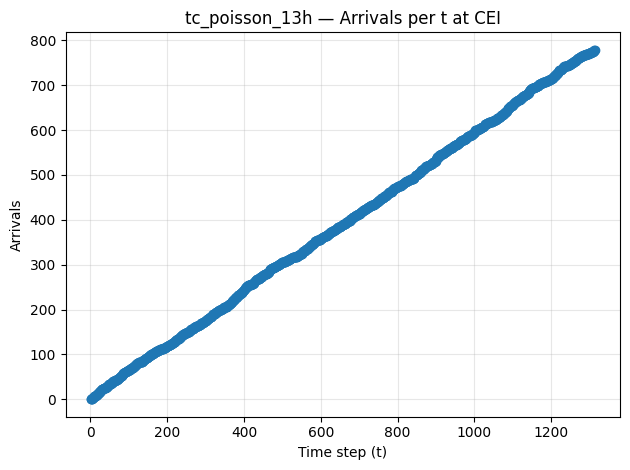

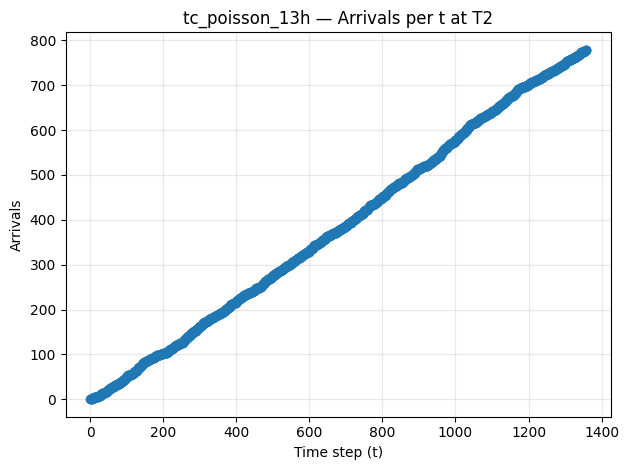

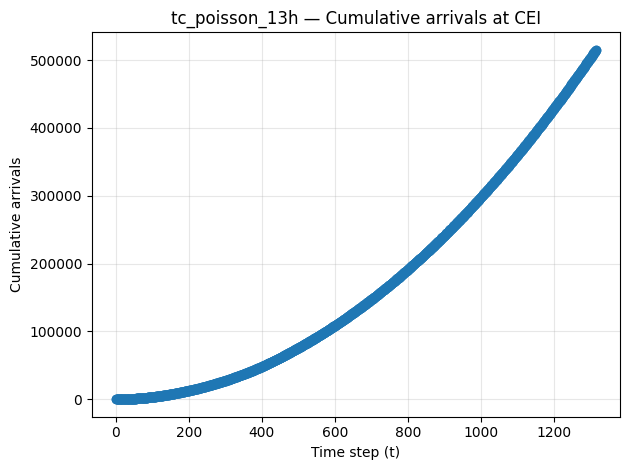

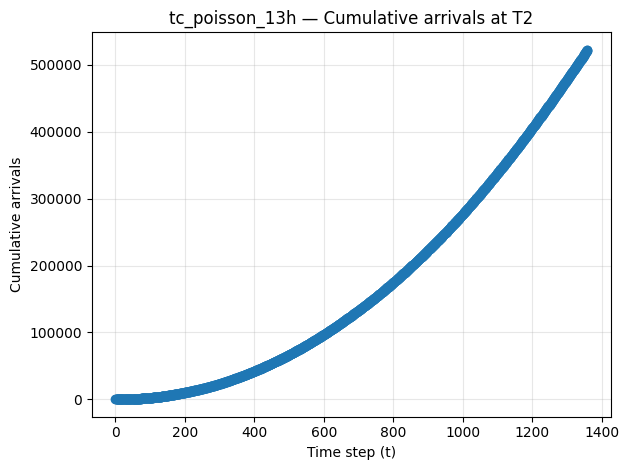

In [5]:
evbus_viz("/home/hpcnc/bus_opt/case/tc_poisson_13h.json", save_csv=False)

=== CEI ===
Mean = 352.550
Variance = 44442.283
Skewness = 0.036
Kurtosis (excess) = -1.232



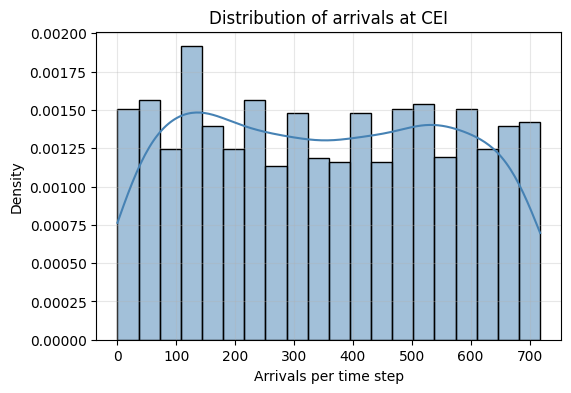

=== T2 ===
Mean = 359.161
Variance = 42849.148
Skewness = 0.022
Kurtosis (excess) = -1.191



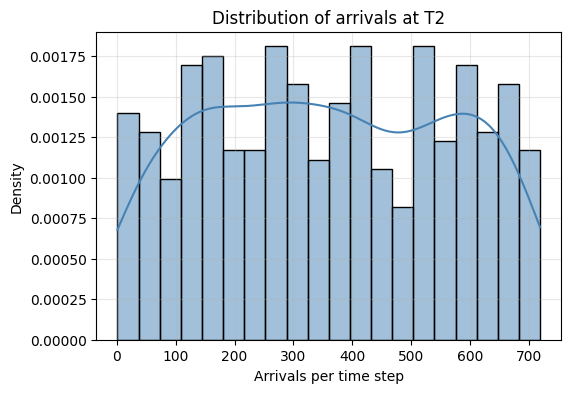

=== CEI ===
Mean = 353.018
Variance = 42394.254
Skewness = 0.055
Kurtosis (excess) = -1.166



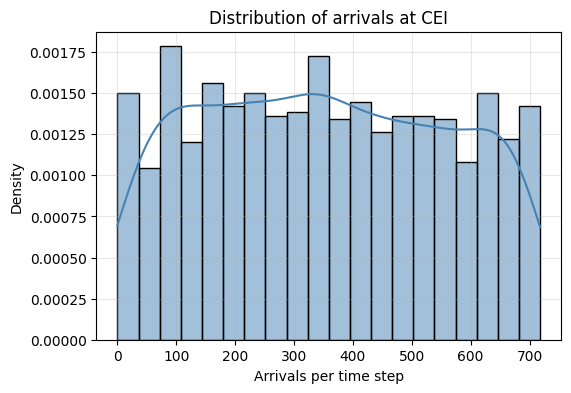

=== T2 ===
Mean = 362.329
Variance = 45218.694
Skewness = -0.016
Kurtosis (excess) = -1.267



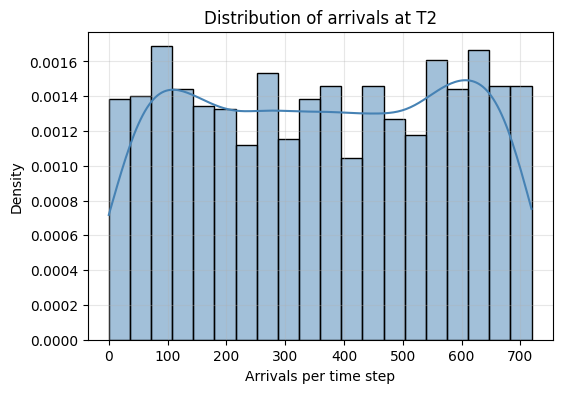

In [14]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# Load arrivals from JSON
def load_arrivals(json_path):
    with open(json_path, "r") as f:
        case = json.load(f)
    arrivals = case["arrivals"]
    rows = []
    for terminal, series in arrivals.items():
        for t_str, val in series.items():
            rows.append({"t": int(t_str), "terminal": terminal, "arrivals": int(val)})
    df = pd.DataFrame(rows)
    return df

# Plot distributions + statistics
def plot_distributions(df):
    terminals = df["terminal"].unique()
    for term in terminals:
        data = df[df["terminal"] == term]["arrivals"]
        
        # Basic stats
        mean_val = data.mean()
        var_val = data.var()
        skew_val = skew(data, bias=False)
        kurt_val = kurtosis(data, fisher=True, bias=False)  # fisher=True = excess kurtosis

        print(f"=== {term} ===")
        print(f"Mean = {mean_val:.3f}")
        print(f"Variance = {var_val:.3f}")
        print(f"Skewness = {skew_val:.3f}")
        print(f"Kurtosis (excess) = {kurt_val:.3f}")
        print()

        # Histogram + KDE
        plt.figure(figsize=(6,4))
        sns.histplot(data, bins=20, kde=True, stat="density", color="steelblue")
        plt.title(f"Distribution of arrivals at {term}")
        plt.xlabel("Arrivals per time step")
        plt.ylabel("Density")
        plt.grid(True, alpha=0.3)
        plt.show()

# Example usage
df_tc6 = load_arrivals("/home/hpcnc/bus_opt/case/tc_75_40_30_4.json")
plot_distributions(df_tc6)

df_poisson = load_arrivals("/home/hpcnc/bus_opt/case/tc_115_115_45_7.json")
plot_distributions(df_poisson)


# CONVERT TO CSV

In [16]:
import json
import pandas as pd
from collections import defaultdict

with open("/home/hpcnc/bus_opt/output/tc_75_40_45_6.json", "r") as f:
    data = json.load(f)

departures = pd.DataFrame(data["departures"])

passenger_counts = defaultdict(int)
for a in data["assignments"]:
    key = (a["t"], a["terminal"], a["bus"])
    passenger_counts[key] += 1


passenger_summary = pd.DataFrame([
    {"t": t, "terminal": terminal, "bus": bus, "passengers": count}
    for (t, terminal, bus), count in passenger_counts.items()
])

schedule = departures.merge(passenger_summary, on=["t", "terminal", "bus"], how="left")
schedule["passengers"] = schedule["passengers"].fillna(0).astype(int)

# schedule.to_csv("bus_schedule.csv", index=False)

print(schedule)


       t terminal  bus  passengers
0      0      CEI    4           1
1      0      CEI    5           0
2      0      CEI    6           0
3     40      CEI    1          20
4     40      CEI    2          19
..   ...      ...  ...         ...
108  720      CEI    6          20
109  760       T2    1           0
110  760      CEI    2           0
111  760      CEI    3           0
112  760      CEI    5           0

[113 rows x 4 columns]


In [9]:
from glob import glob
from pathlib import Path

LOG = Path("/home/hpcnc/bus_opt/log").glob("*")
OUTPUT = Path("/home/hpcnc/bus_opt/output").glob("*")

log = []
output = []

for l in LOG:
    log.append(l.stem)

for o in OUTPUT:
    output.append(o.stem)


In [12]:
PASS = []
for i in log:
    if i not in output:
        PASS.append(i)